In [1]:
import os,librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd

In [40]:
seed=42
n_MFCC=13
column_names= ['MFCC_'+str(i) for i in range(1,n_MFCC+1)]

In [41]:
DATA_PATH="./Vowel_Data/Vowel/"

In [42]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [43]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Speech of label -'vowel7': 100%|██████████| 40/40 [00:00<00:00, 122.64it/s]


In [44]:
np.random.seed(seed)
model_v=Sequential()
model_v.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [45]:
model_v.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['AUC']
)

In [46]:
history_v=model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 277ms/step - loss: 1.9703 - auc: 0.5824 - val_loss: 1.8503 - val_auc: 0.6475
Epoch 2/50
1/1 [==============================] - 0s 83ms/step - loss: 1.8522 - auc: 0.6489 - val_loss: 1.7439 - val_auc: 0.7095
Epoch 3/50
1/1 [==============================] - 0s 101ms/step - loss: 1.7465 - auc: 0.7086 - val_loss: 1.6492 - val_auc: 0.7607
Epoch 4/50
1/1 [==============================] - 0s 74ms/step - loss: 1.6523 - auc: 0.7587 - val_loss: 1.5649 - val_auc: 0.8002
Epoch 5/50
1/1 [==============================] - 0s 76ms/step - loss: 1.5683 - auc: 0.7977 - val_loss: 1.4897 - val_auc: 0.8295
Epoch 6/50
1/1 [==============================] - 0s 81ms/step - loss: 1.4932 - auc: 0.8271 - val_loss: 1.4227 - val_auc: 0.8514
Epoch 7/50
1/1 [==============================] - 0s 80ms/step - loss: 1.4261 - auc: 0.8491 - val_loss: 1.3629 - val_auc: 0.8677
Epoch 8/50
1/1 [==============================] - 0s 85ms/step - loss: 1.3661 - auc: 0.8655 - v

In [47]:
history_dict=history_v.history

loss_v=history_dict['loss']
val_loss_v=history_dict['val_loss']

auc_v=history_dict['auc']
val_auc_v=history_dict['val_auc']

In [48]:
epochs=range(1,len(loss_v)+1)
ticks=[1]
ticks2=[i for i in range(5,len(loss_v)+1,5)]
ticks.extend(ticks2)

In [49]:
save_specifier='standard_mfcc_32_16_tanh_softmax_adam_005_batchfull_seed42'

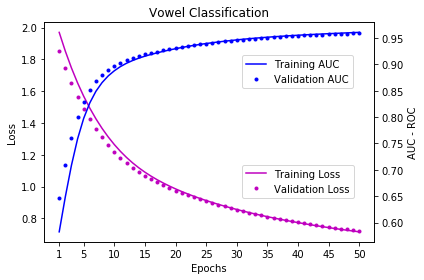

In [50]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'m', label='Training Loss')
ln2=ax.plot(epochs,val_loss_v,'m.', label='Validation Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_v,'b', label='Training AUC')
ln3=ax2.plot(epochs,val_auc_v,'b.', label='Validation AUC')

ax.set_title('Vowel Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.7))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
plt.savefig('./New_without_CNN/loss_auc_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [51]:
DATA_PATH="./Word_Data/Word/"

In [52]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [53]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Speech of label -'Word7': 100%|██████████| 40/40 [00:00<00:00, 100.34it/s]


In [54]:
np.random.seed(seed)
model_w=Sequential()
model_w.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [55]:
model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['AUC']
)

In [56]:
history_w=model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 315ms/step - loss: 2.0537 - auc: 0.4962 - val_loss: 1.9937 - val_auc: 0.5349
Epoch 2/50
1/1 [==============================] - 0s 87ms/step - loss: 1.9801 - auc: 0.5459 - val_loss: 1.9263 - val_auc: 0.5841
Epoch 3/50
1/1 [==============================] - 0s 137ms/step - loss: 1.9138 - auc: 0.5952 - val_loss: 1.8660 - val_auc: 0.6288
Epoch 4/50
1/1 [==============================] - 0s 96ms/step - loss: 1.8547 - auc: 0.6387 - val_loss: 1.8125 - val_auc: 0.6657
Epoch 5/50
1/1 [==============================] - 0s 101ms/step - loss: 1.8023 - auc: 0.6746 - val_loss: 1.7652 - val_auc: 0.6955
Epoch 6/50
1/1 [==============================] - 0s 122ms/step - loss: 1.7559 - auc: 0.7032 - val_loss: 1.7234 - val_auc: 0.7193
Epoch 7/50
1/1 [==============================] - 0s 103ms/step - loss: 1.7150 - auc: 0.7257 - val_loss: 1.6863 - val_auc: 0.7380
Epoch 8/50
1/1 [==============================] - 0s 99ms/step - loss: 1.6788 - auc: 0.7433 

In [57]:
history_dict=history_w.history
loss_w=history_dict['loss']
val_loss_w=history_dict['val_loss']

auc_w=history_dict['auc']
val_auc_w=history_dict['val_auc']

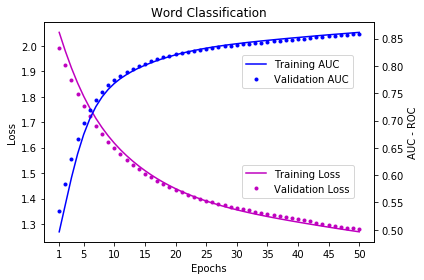

In [58]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_w,'m', label='Training Loss')
ln2=ax.plot(epochs,val_loss_w,'m.', label='Validation Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_w,'b', label='Training AUC')
ln3=ax2.plot(epochs,val_auc_w,'b.', label='Validation AUC')

ax.set_title('Word Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.7))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
plt.savefig('./New_without_CNN/loss_auc_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [59]:
#COMPARE

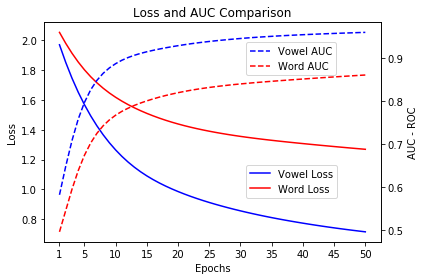

In [60]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'b', label='Vowel Loss')
ln2=ax.plot(epochs,loss_w,'r', label='Word Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_v,'b--', label='Vowel AUC')
ln3=ax2.plot(epochs,auc_w,'r--', label='Word AUC')

ax.set_title('Loss and AUC Comparison')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.76))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
plt.savefig('./New_without_CNN/comare_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [61]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./New_without_CNN/all_compare_data_'+save_specifier+'.csv')

In [67]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.087982,1.079178,0.578892,0.576316,0.914252,0.914130,1.465496,1.461363,0.433841,0.435846,0.808475,0.810116
46,1.073246,1.063786,0.580471,0.586316,0.916134,0.916380,1.460930,1.456924,0.435345,0.437049,0.809607,0.811218
47,1.058198,1.051638,0.585735,0.577368,0.918239,0.917834,1.456578,1.452782,0.435445,0.443865,0.810850,0.812264
48,1.043170,1.040124,0.585867,0.578421,0.920454,0.919898,1.452407,1.448659,0.439755,0.447875,0.812117,0.813237
49,1.030735,1.028717,0.590604,0.581053,0.922445,0.921268,1.448298,1.444540,0.444968,0.446672,0.813397,0.814203


In [45]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,0.747012,0.753977,0.741413,0.727895,0.960994,0.959738,1.281573,1.291772,0.509824,0.504010,0.859364,0.856465
46,0.740706,0.747679,0.742203,0.727895,0.961514,0.960330,1.277932,1.287836,0.511628,0.503609,0.860304,0.857371
47,0.734629,0.741603,0.743387,0.728421,0.961970,0.960810,1.274361,1.283999,0.512831,0.503609,0.861195,0.858353
48,0.728761,0.735736,0.745493,0.731053,0.962445,0.961305,1.270858,1.280256,0.513031,0.506816,0.862042,0.859321
49,0.723083,0.730062,0.745756,0.734211,0.962883,0.961810,1.267420,1.276603,0.514635,0.510024,0.862903,0.860176


In [28]:
all_compare_df.tail()

,loss_v,val_loss_v,auc_v,val_auc_v,loss_w,val_loss_w,auc_w,val_auc_w
45,0.706936,0.714525,0.963838,0.962377,1.309307,1.312979,0.854070,0.852646
46,0.701005,0.709404,0.964249,0.962680,1.304894,1.309166,0.855060,0.853603
47,0.695289,0.704458,0.964672,0.963047,1.300554,1.305393,0.856125,0.854472
48,0.689775,0.699667,0.965066,0.963378,1.296285,1.301660,0.857146,0.855276
49,0.684449,0.695019,0.965437,0.963702,1.292087,1.297965,0.858121,0.855980


In [62]:
all_compare_df.tail()

,loss_v,val_loss_v,auc_v,val_auc_v,loss_w,val_loss_w,auc_w,val_auc_w
45,0.735822,0.740672,0.958826,0.957656,1.283517,1.293495,0.857910,0.855152
46,0.730334,0.735616,0.959333,0.958082,1.279773,1.289651,0.858789,0.856155
47,0.725022,0.730728,0.959823,0.958516,1.276084,1.285892,0.859699,0.856994
48,0.719872,0.725991,0.960334,0.958967,1.272452,1.282220,0.860599,0.857870
49,0.714867,0.721389,0.960773,0.959409,1.268873,1.278631,0.861462,0.858814
